# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from dqn_agent import Agent
from collections import deque
import time
import torch
from itertools import count

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

In [2]:
env = UnityEnvironment(file_name='env/Reacher_Linux_NoVis/Reacher.x86')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
brain_name = env.brain_names[0]
print(brain_name)
brain = env.brains[brain_name]

ReacherBrain


### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


## 4.  Train!

In [6]:
env_info = env.reset(train_mode=True)[brain_name]
agent = Agent(state_size=state_size, action_size=action_size, random_seed=15)
avg_over = 100
print_every = 10

In [7]:
def ddpg(n_episodes=200):
    scores_deque = deque(maxlen=avg_over)
    scores_global = []
    average_global = []
    best_avg = -np.inf
    solved = False
    tic = time.time()
        
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      
        states = env_info.vector_observations                 
        scores = np.zeros(num_agents)                         
        agent.reset()
        
        score_average = 0
        timestep = time.time()
        for t in count():
            actions = agent.act(states, add_noise=True)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            agent.step(states, actions, rewards, next_states, dones, t)
            states = next_states                               # roll over states to next time step
            scores += rewards                                  # update the score (for each agent)            
            if np.any(dones):                                  # exit loop if episode finished
                break
        
        score = np.mean(scores)
        scores_deque.append(score)
        score_average = np.mean(scores_deque)
        scores_global.append(score)
        average_global.append(score_average)
                
        print('\rEpisode {}, Average Score: {:.2f}, Max Score: {:.2f}, Min Score: {:.2f}, Time per Episode: {:.2f}'\
              .format(i_episode, score_average, np.max(scores), np.min(scores), time.time() - timestep), end="\n")        
        
        if i_episode % print_every == 0:
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))   
            
        if score_average >= 30.0:
            toc = time.time()
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}, training time: {}'.format(i_episode, score_average, toc-tic))
            torch.save(agent.actor_local.state_dict(), 'best_checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'best_checkpoint_critic.pth')
            break;
    return scores_global, average_global

In [12]:
scores = ddpg()

Episode 1, Average Score: 0.01, Max Score: 0.11, Min Score: 0.00, Time per Episode: 15.12
Episode 2, Average Score: 0.08, Max Score: 0.72, Min Score: 0.00, Time per Episode: 15.49
Episode 3, Average Score: 0.13, Max Score: 0.58, Min Score: 0.00, Time per Episode: 15.32
Episode 4, Average Score: 0.28, Max Score: 1.90, Min Score: 0.09, Time per Episode: 15.66
Episode 5, Average Score: 0.35, Max Score: 1.56, Min Score: 0.23, Time per Episode: 16.20
Episode 6, Average Score: 0.41, Max Score: 1.96, Min Score: 0.12, Time per Episode: 15.00
Episode 7, Average Score: 0.47, Max Score: 1.47, Min Score: 0.14, Time per Episode: 16.00
Episode 8, Average Score: 0.52, Max Score: 2.02, Min Score: 0.16, Time per Episode: 16.25
Episode 9, Average Score: 0.56, Max Score: 1.64, Min Score: 0.44, Time per Episode: 16.73
Episode 10, Average Score: 0.58, Max Score: 1.94, Min Score: 0.00, Time per Episode: 15.62
Episode 10	Average Score: 0.58
Episode 11, Average Score: 0.60, Max Score: 1.76, Min Score: 0.13, T

Episode 88, Average Score: 5.72, Max Score: 22.63, Min Score: 4.68, Time per Episode: 23.77
Episode 89, Average Score: 5.86, Max Score: 36.88, Min Score: 5.09, Time per Episode: 21.94
Episode 90, Average Score: 6.00, Max Score: 26.01, Min Score: 5.46, Time per Episode: 23.69
Episode 90	Average Score: 6.00
Episode 91, Average Score: 6.08, Max Score: 32.75, Min Score: 2.07, Time per Episode: 23.25
Episode 92, Average Score: 6.19, Max Score: 22.06, Min Score: 2.00, Time per Episode: 23.12
Episode 93, Average Score: 6.30, Max Score: 21.49, Min Score: 7.24, Time per Episode: 22.22
Episode 94, Average Score: 6.42, Max Score: 26.70, Min Score: 6.44, Time per Episode: 22.32
Episode 95, Average Score: 6.53, Max Score: 25.86, Min Score: 5.13, Time per Episode: 22.01
Episode 96, Average Score: 6.67, Max Score: 34.14, Min Score: 7.36, Time per Episode: 22.37
Episode 97, Average Score: 6.79, Max Score: 34.79, Min Score: 5.38, Time per Episode: 22.98
Episode 98, Average Score: 6.95, Max Score: 29.25

Episode 172, Average Score: 26.15, Max Score: 38.28, Min Score: 23.50, Time per Episode: 22.46
Episode 173, Average Score: 26.40, Max Score: 38.43, Min Score: 30.24, Time per Episode: 24.94
Episode 174, Average Score: 26.66, Max Score: 39.42, Min Score: 28.71, Time per Episode: 22.27
Episode 175, Average Score: 26.91, Max Score: 39.50, Min Score: 30.53, Time per Episode: 23.37
Episode 176, Average Score: 27.14, Max Score: 39.36, Min Score: 26.46, Time per Episode: 22.18
Episode 177, Average Score: 27.36, Max Score: 39.50, Min Score: 25.76, Time per Episode: 22.05
Episode 178, Average Score: 27.57, Max Score: 39.15, Min Score: 27.16, Time per Episode: 24.17
Episode 179, Average Score: 27.80, Max Score: 39.62, Min Score: 29.85, Time per Episode: 22.67
Episode 180, Average Score: 28.04, Max Score: 39.29, Min Score: 30.00, Time per Episode: 24.79
Episode 180	Average Score: 28.04
Episode 181, Average Score: 28.25, Max Score: 38.98, Min Score: 31.42, Time per Episode: 22.04
Episode 182, Aver

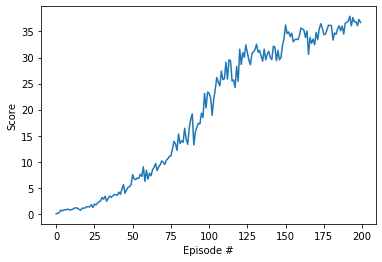

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [14]:
agent.qnetwork_local.load_state_dict(torch.load('checkpoint.pth'))

checkpoint_critic.pth
for i in range(5):
    state = env.reset()
    for j in range(200):
        action = agent.act(state)
        env.render()
        state, reward, done, _ = env.step(action)
        if done:
            break 

AttributeError: 'Agent' object has no attribute 'qnetwork_local'

When finished, you can close the environment.

In [ ]:
# env.close()